In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [3]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO

# Configuration
ROOT_DATASET_DIR = '/kaggle/input/s-2025-multi-class-pretraied-network-project/Data/Train'
OUTPUT_NPY_IMAGES = 'images.npy'
OUTPUT_NPY_LABELS = 'labels.npy'
IMG_SIZE = (224, 224)
SAVE_DIR = 'cropped_faces'

# Load YOLO face detection model
yolo_model = YOLO("/kaggle/input/yolov11-face/pytorch/default/1/yolov11n-face.pt")

# Step 1: Map folder names to labels
class_dirs = sorted(d for d in os.listdir(ROOT_DATASET_DIR) if os.path.isdir(os.path.join(ROOT_DATASET_DIR, d)))
label_map = {}
for d in class_dirs:
    try:
        lbl = int(d)
    except ValueError:
        raise ValueError(f"Folder name '{d}' is not an integer label!")
    label_map[d] = lbl

# Step 2: Prepare image paths and labels
image_paths = []
labels = []
for folder_name in class_dirs:
    lbl = label_map[folder_name]
    folder_path = os.path.join(ROOT_DATASET_DIR, folder_name)
    for fn in os.listdir(folder_path):
        if fn.lower().endswith(('.png', '.jpg', 'jpeg', '.bmp', '.gif')):
            image_paths.append(os.path.join(folder_path, fn))
            labels.append(lbl)

num_images = len(image_paths)
print(f"Found {num_images} images.")

# Step 3: Preallocate arrays
images_array = np.zeros((num_images, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
labels_array = np.array(labels, dtype=np.int32)

# Step 4: Create label folders inside cropped_faces
unique_labels = sorted(set(labels))
for lbl in unique_labels:
    os.makedirs(os.path.join(SAVE_DIR, str(lbl)), exist_ok=True)

# Step 5: Process and save images
face_cropped_count = 0

for i, (img_path, label) in enumerate(tqdm(zip(image_paths, labels), total=num_images, desc='Processing images')):
    try:
        pil_img = Image.open(img_path).convert('RGB')
        img_np = np.array(pil_img)

        # Face detection
        results = yolo_model.predict(img_np, conf=0.5, verbose=False)
        boxes = results[0].boxes

        if boxes.shape[0] > 0:
            face_cropped_count += 1
            x1, y1, x2, y2 = boxes[0].xyxy[0].cpu().numpy().astype(int)
            face_crop = img_np[y1:y2, x1:x2]
            face_pil = Image.fromarray(face_crop).resize(IMG_SIZE, Image.LANCZOS)
        else:
            face_pil = pil_img.resize(IMG_SIZE, Image.LANCZOS)

        # Save in .npy array
        images_array[i] = np.array(face_pil)

        # Save image into corresponding folder
        save_path = os.path.join(SAVE_DIR, str(label), f"img_{i:05d}.jpg")
        face_pil.save(save_path)

    except Exception as e:
        print(f"[!] Skipped {img_path}: {e}")

# Step 6: Save .npy arrays
np.save(OUTPUT_NPY_IMAGES, images_array)
np.save(OUTPUT_NPY_LABELS, labels_array)

print(f"\n✅ Saved {OUTPUT_NPY_IMAGES} and {OUTPUT_NPY_LABELS}")
print(f"✅ Cropped faces: {face_cropped_count} out of {num_images} images")
print(f"🖼️  Preprocessed images saved in folders under: {SAVE_DIR}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Found 4587 images.


Processing images: 100%|██████████| 4587/4587 [02:14<00:00, 34.02it/s]



✅ Saved images.npy and labels.npy
✅ Cropped faces: 4538 out of 4587 images
🖼️  Preprocessed images saved in folders under: cropped_faces


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import pandas as pd
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
# --- 1) CONFIGURATION ------------------------------------------------------
IMAGES_PATH   = 'images.npy'
LABELS_PATH   = 'labels.npy'
NUM_CLASSES   = 16
BATCH_SIZE    = 32
IMAGE_SIZE    = (224, 224)
EPOCHS_PHASE1 = 70
EPOCHS_PHASE2 = 50
MIXUP_ALPHA   = 0.4  # MixUp hyperparameter

# --- 2) MIXUP UTILITIES -----------------------------------------------------
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- 3) AUGMENTATION PIPELINE ------------------------------------------------
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),  # ±20°
    # Removed RandomResizedCrop
    A.HueSaturationValue(
        hue_shift_limit=3,      # ±2% of 180 ≈ 3.6
        sat_shift_limit=25,     # ±10% of 255 ≈ 25.5
        val_shift_limit=51,     # ±20% of 255 ≈ 51
        p=0.7
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.2,   # ±20%
        contrast_limit=0.1,     # ±10%
        p=0.7
    ),
    A.CoarseDropout(num_holes_range=(1,2), hole_height_range=(0.1,0.2),
                    hole_width_range=(0.1,0.2), fill=0, p=0.5),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2()
])

# --- 4) DATASET --------------------------------------------------------------
class NumpyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        # remap -1→15
        labels = np.where(labels == -1, NUM_CLASSES-1, labels)
        self.images = images
        self.labels = labels.astype(np.int64)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]
        if self.transform:
            img = self.transform(image=img)['image']
        return img, lbl

# --- 5) MODEL SETUP ---------------------------------------------------------
def create_model():
    model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
    in_f = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_f, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )
    return model


def train_model():
    images = np.load(IMAGES_PATH)
    labels = np.load(LABELS_PATH)
    labels = np.where(labels == -1, NUM_CLASSES-1, labels)
    
    # Create full dataset first
    full_dataset = NumpyDataset(images, labels, transform=train_transform)
    
    # Split before computing weights
    n_train = int(0.8 * len(full_dataset))
    n_val = len(full_dataset) - n_train
    train_ds, val_ds = random_split(full_dataset, [n_train, n_val])
    
    # Get training labels ONLY from training subset
    train_indices = train_ds.indices
    train_labels = full_dataset.labels[train_indices]
    
    # Compute weights ONLY for training set
    class_sample_count = np.bincount(train_labels, minlength=NUM_CLASSES)
    class_weights = 1.0 / class_sample_count
    sample_weights = class_weights[train_labels]
    
    # Create sampler using training subset weights
    sampler = WeightedRandomSampler(
        sample_weights, 
        num_samples=len(sample_weights), 
        replacement=True
    )
    
    # DataLoaders
    train_loader = DataLoader(
        train_ds, 
        batch_size=BATCH_SIZE, 
        sampler=sampler,
        num_workers=4, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=4, 
        pin_memory=True
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = create_model().to(device)
    crit   = nn.CrossEntropyLoss()
    opt    = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience_limit = 10
    best_model_state = None

    # --- Initialize history lists ---
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Phase 1: head only
    for p in model.parameters(): p.requires_grad = False
    for p in model.classifier.parameters(): p.requires_grad = True
    
    for epoch in range(EPOCHS_PHASE1):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            x_m, y_a, y_b, lam = mixup_data(x, y, MIXUP_ALPHA)
            opt.zero_grad()
            preds = model(x_m)
            loss  = mixup_criterion(crit, preds, y_a, y_b, lam)
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            # For train accuracy, use non-mixed labels
            out = model(x)
            correct_train += (out.argmax(1) == y).sum().item()
            total_train += y.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        print(f"[Head] Epoch {epoch+1}/{EPOCHS_PHASE1} train loss: {train_loss:.4f} | train acc: {train_acc:.2f}%")
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                val_loss += crit(out, y).item() * x.size(0)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        print(f"         Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print("         New best model saved!")
        else:
            patience_counter += 1
            print(f"         Patience counter: {patience_counter}/{patience_limit}")
        if patience_counter >= patience_limit:
            print("         Early stopping triggered!")
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model from Phase 1")
    
    # Phase 2: fine-tune last blocks + head
    for p in model.parameters(): p.requires_grad = False
    for blk in model.features[-5:]:
        for p in blk.parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True
    
    opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=5, verbose=True
    )
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(EPOCHS_PHASE2):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            x_m, y_a, y_b, lam = mixup_data(x, y, MIXUP_ALPHA)
            opt.zero_grad()
            preds = model(x_m)
            loss  = mixup_criterion(crit, preds, y_a, y_b, lam)
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            out = model(x)
            correct_train += (out.argmax(1) == y).sum().item()
            total_train += y.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        print(f"[Fine] Epoch {epoch+1}/{EPOCHS_PHASE2} train loss: {train_loss:.4f} | train acc: {train_acc:.2f}%")
        
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                val_loss += crit(out, y).item() * x.size(0)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        print(f"         Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print("         New best model saved!")
        else:
            patience_counter += 1
            print(f"         Patience counter: {patience_counter}/{patience_limit}")
        if patience_counter >= patience_limit:
            print("         Early stopping triggered!")
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model from Phase 2")
    
    # --- Save history dict ---
    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }
    np.save('history.npy', history)
    print("Training history saved to history.npy")
    return model, history


In [6]:
print("Starting training...")
model,history = train_model()
torch.save(model.state_dict(), "CV_Project_Part1_with_accuracy.pth")

Starting training...


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 165MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Head] Epoch 1/70 train loss: 2.5639 | train acc: 21.45%
         Val Loss: 2.2915 | Val Acc: 27.78%
         New best model saved!
[Head] Epoch 2/70 train loss: 2.3375 | train acc: 33.28%
         Val Loss: 2.2395 | Val Acc: 29.63%
         New best model saved!
[Head] Epoch 3/70 train loss: 2.2485 | train acc: 37.37%
         Val Loss: 2.0122 | Val Acc: 38.78%
         New best model saved!
[Head] Epoch 4/70 train loss: 2.2382 | train acc: 38.38%
         Val Loss: 2.0228 | Val Acc: 36.49%
         Patience counter: 1/10
[Head] Epoch 5/70 train loss: 2.1961 | train acc: 40.09%
         Val Loss: 1.9213 | Val Acc: 39.98%
         New best model saved!
[Head] Epoch 6/70 train loss: 2.2015 | train acc: 41.76%
         Val Loss: 1.8708 | Val Acc: 41.07%
         New best model saved!
[Head] Epoch 7/70 train loss: 2.1943 | train acc: 40.26%
         Val Loss: 1.8401 | Val Acc: 43.46%
         New best model saved!
[Head] Epoch 8/70 train loss: 2.0449 | train acc: 42.63%
         Val Loss:

In [7]:
!pip install thop

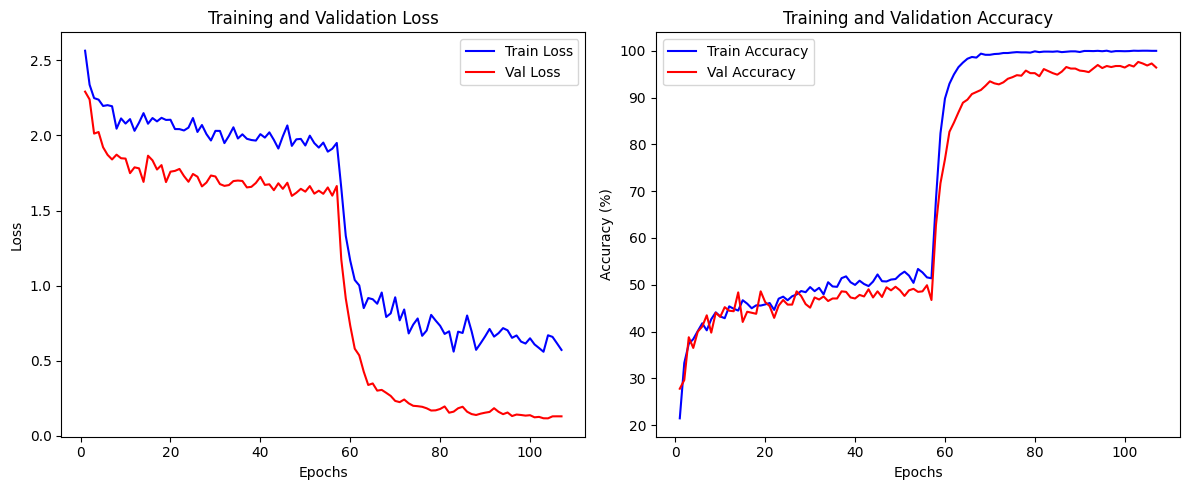

In [15]:
import matplotlib.pyplot as plt

def plot_train_val_metrics(data):
    epochs = range(1, len(data['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, data['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, data['val_loss'], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, data['train_acc'], 'b-', label='Train Accuracy')
    plt.plot(epochs, data['val_acc'], 'r-', label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_train_val_metrics(history)

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    top1_correct = 0
    top3_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # logits
            _, preds_top1 = outputs.topk(1, dim=1)
            _, preds_top3 = outputs.topk(3, dim=1)

            total += labels.size(0)

            # Top-1 accuracy
            top1_correct += (preds_top1.squeeze() == labels).sum().item()

            # Top-3 accuracy
            top3_correct += sum([labels[i] in preds_top3[i] for i in range(labels.size(0))])

            # Save all preds and labels for metric computation
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute scores
    top1_acc = top1_correct / total
    top3_acc = top3_correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Print
    print(f"Top-1 Accuracy: {top1_acc*100:.2f}%")
    print(f"Top-3 Accuracy: {top3_acc*100:.2f}%")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")

    return top1_acc, top3_acc, f1, precision, recall


In [21]:



# Preprocessing pipeline for validation (same as test)
val_transform = A.Compose([
    A.Resize(*IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

images = np.load(IMAGES_PATH)
labels = np.load(LABELS_PATH)

# Create dataset and split
full_dataset = NumpyDataset(images, labels, transform=val_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_ds = random_split(
    full_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # Same seed as training
)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Evaluate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device).eval()

top1_acc, top3_acc, f1, precision, recall = evaluate_model(model, val_loader, device)

print(f"\n→ Final results on validation set:")
print(f"   • Top-1 Accuracy: {top1_acc*100:.2f}%")
print(f"   • Top-3 Accuracy: {top3_acc*100:.2f}%")
print(f"   • F1 Score (weighted): {f1:.4f}")
print(f"   • Precision (weighted): {precision:.4f}")
print(f"   • Recall (weighted): {recall:.4f}")


Top-1 Accuracy: 99.67%
Top-3 Accuracy: 100.00%
F1 Score (weighted): 0.9967
Precision (weighted): 0.9968
Recall (weighted): 0.9967

→ Final results on validation set:
   • Top-1 Accuracy: 99.67%
   • Top-3 Accuracy: 100.00%
   • F1 Score (weighted): 0.9967
   • Precision (weighted): 0.9968
   • Recall (weighted): 0.9967


In [22]:
# ─── CONFIG ───────────────────────────────────────────────
TEST_DIR        = '/kaggle/input/s-2025-multi-class-pretraied-network-project/Data/Pridect'
YOLO_MODEL_PATH = '/kaggle/input/yolov11-face/pytorch/default/1/yolov11n-face.pt'
OUTPUT_SUB_CSV  = 'F2022376120_final_submission.csv'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize YOLO model ONCE in main process
yolo_model = YOLO(YOLO_MODEL_PATH)

# ─── PREPROCESSING ───────────────────────────────────────
test_transform = A.Compose([
    A.Resize(*IMAGE_SIZE),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2()
])

# ─── DATASET ─────────────────────────────────────────────
class TestDataset(Dataset):
    def __init__(self, test_dir, transform):
        self.test_dir = test_dir
        self.ids = sorted(os.listdir(test_dir))
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        fn = self.ids[i]
        path = os.path.join(self.test_dir, fn)
        pil_img = Image.open(path).convert('RGB')
        img_np = np.array(pil_img)

        # Face Detection - using global yolo_model
        results = yolo_model.predict(img_np, conf=0.5, verbose=False)
        boxes = results[0].boxes

        if boxes.shape[0] > 0:
            x1, y1, x2, y2 = boxes[0].xyxy[0].cpu().numpy().astype(int)
            face = img_np[y1:y2, x1:x2]
            face = Image.fromarray(face).resize(IMAGE_SIZE, Image.LANCZOS)
        else:
            face = pil_img.resize(IMAGE_SIZE, Image.LANCZOS)

        face_np = np.array(face)
        tensor = self.transform(image=face_np)['image']
        return fn, tensor

# # Load and prepare model
# model = create_model().to(DEVICE)
# model.load_state_dict(torch.load('/kaggle/working/CV_Project_Part1_with_accuracy.pth'))
model.eval()

# ─── INFERENCE ────────────────────────────────────────────
# Use num_workers=0 to avoid multiprocessing issues
ds = TestDataset(TEST_DIR, test_transform)
dl = DataLoader(ds, batch_size=BATCH_SIZE, num_workers=0)  # Critical fix

ids, preds = [], []

with torch.no_grad():
    for batch in tqdm(dl, desc="Processing Test Images"):
        fns, imgs = batch
        imgs = imgs.to(DEVICE)
        out = model(imgs)
        label_idxs = out.argmax(dim=1).cpu().numpy()
        label_idxs = [(-1 if l == 15 else int(l)) for l in label_idxs]
        ids.extend(fns)
        preds.extend(label_idxs)

# # ─── SAVE SUBMISSION ─────────────────────────────────────
# # Remove file extensions from IDs
# clean_ids = [os.path.splitext(id)[0] for id in ids]

df = pd.DataFrame({'Id': ids, 'Label': preds})
df.to_csv(OUTPUT_SUB_CSV, index=False)
print(f"✅ Saved submission: {OUTPUT_SUB_CSV}")
print(f"Sample submission:\n{df.head()}")


Processing Test Images: 100%|██████████| 14/14 [00:13<00:00,  1.04it/s]

✅ Saved submission: F2022376120_final_submission.csv
Sample submission:
                     Id  Label
0  03puXl3nDjj6HVrJ.jpg      6
1  0BPr2ahEjy1W2bs9.jpg      8
2  0WxoHhIrQeAYksk9.jpg     -1
3  0jel9ODjtQ9CR5OQ.jpg      8
4  0z6DCHp5qL0NOby9.jpg      3


In [13]:
from thop import profile

# Create dummy input on the same device as model
device = next(model.parameters()).device
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Compute MACs and Params
macs, params = profile(model, inputs=(dummy_input,))

# Convert to readable units
flops = 2 * macs
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")         # Giga = billions
print(f"MACs : {macs / 1e9:.2f} GMACs")
print(f"Parameters: {params / 1e6:.2f} Million")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
FLOPs: 17.41 GFLOPs
MACs : 8.70 GMACs
Parameters: 20.84 Million
